In [27]:
import numpy as np
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt
import pymc as pm
from adm import BaconAdm as AgeDepthModel

prefix = "P2"
iData = az.from_netcdf(f"../results/{prefix}_result.nc")

In [28]:
from data_handling import Data

core_id = prefix
arch_data = pd.read_csv("../dat/real_arch_data.csv")
sed_data = pd.read_csv(f"../dat/sed_data/{core_id}_prepared.csv")
adm_data = pd.read_csv(f"../dat/sed_data/{core_id}_adm_data.csv")
arch = Data(arch_data)
sed = Data(sed_data, adm_data)

In [29]:
age0 = 1950 - adm_data['t'][adm_data['depth'] == 0].item()
dage0 = adm_data['dt'][adm_data['depth'] == 0].item()
with pm.Model() as _:
    adm = AgeDepthModel(core_id, sed)

In [30]:
dd = adm.dd.value
D = adm.D
thin = 1

a_samps = np.array(iData.posterior[f"a_{core_id}"])
a_samps = a_samps[:, ::thin].reshape(-1, D).T

theta_samps = np.array(iData.posterior[f"theta_{core_id}"])
theta_samps = theta_samps[:, ::thin].flatten()

sum_a_samps = np.cumsum(a_samps, axis=0)

z = np.linspace(0, D*dd-0.1, 1001)
ind = (z // dd).astype(int)

t_samps = theta_samps + sum_a_samps[ind] * dd + a_samps[ind] * (z - dd * (ind+1))[:, None]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


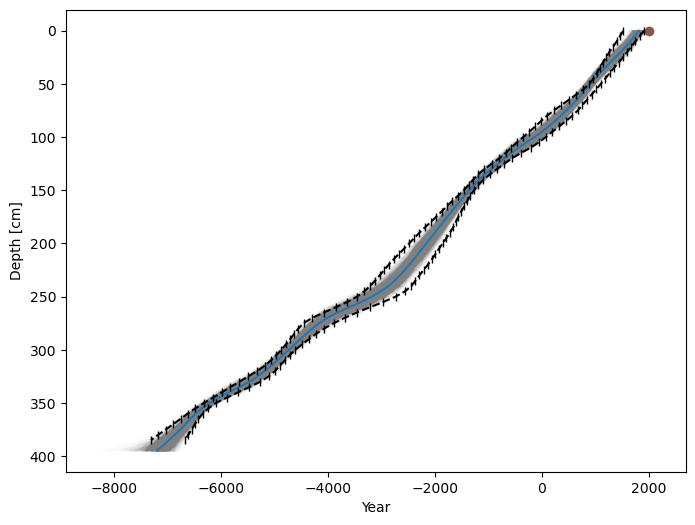

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(
    1950 - t_samps,
    z,
    zorder=0,
    color='grey',
    alpha=0.005,
)

ax.plot(1950 - t_samps.mean(axis=1), z, zorder=0, color="C0")
ax.plot(
    adm_data['t'] + adm_data['dt'],
    adm_data['depth'],
    color='black',
    ls='--',
    marker='|'
)
ax.plot(
    adm_data['t'] - adm_data['dt'],
    adm_data['depth'],
    color='black',
    ls='--',
    marker='|',
)
# ax.errorbar(
#     1950 - adm_data['t'],
#     adm_data['depth'],
#     xerr=adm_data['dt'],
#     color='C0',
#     ls='',
#     marker='o',
# )
# ax.plot(
#     sed_data_dict[core_id]['mag_data']['t'],
#     sed_data_dict[core_id]['mag_data']['depth'],
#     color='C3',
#     ls='--',
# )
ax.scatter(2000, 0, color="C5")
ax.set_xlabel('Year')
ax.set_ylabel('Depth [cm]')
ax.invert_yaxis()
ax.legend(frameon=False)
# ax.set_xlim(-12000, 2000)
# ax.set_ylim(300, 100)

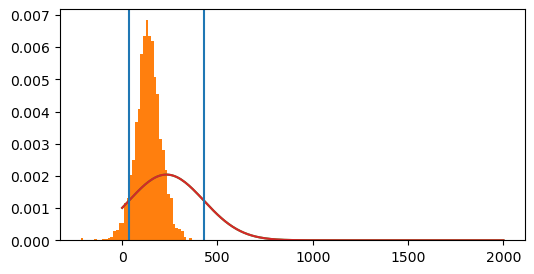

In [32]:
from scipy.stats import norm
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.hist(theta_samps, bins=41, density=True)
ax.hist(t_samps[0], bins=41, density=True)
arr = np.linspace(0, 2000, 201)
ax.plot(arr, norm.pdf(arr, loc=age0, scale=dage0))
ax.plot(arr, norm.pdf(arr, loc=age0, scale=dage0))
ax.axvline(
    1950 - adm_data.loc[0, "t"] + adm_data.loc[0, "dt"],
)
ax.axvline(
    1950 - adm_data.loc[0, "t"] - adm_data.loc[0, "dt"],
)

In [33]:
a_s = iData.posterior[f"lock_in_{core_id}"].values.reshape(-1, 4).T
b_s = np.cumsum(a_s, axis=0)
b_s_mean = b_s.mean(axis=1)
iData.posterior[f"lock_in_{core_id}"].values.mean(axis=1)

array([[ 1.50703064,  2.7897722 , 11.46307429, 28.82080015],
       [ 1.50251105,  2.69700937, 12.20187413, 27.91570028],
       [ 1.46143869,  2.93896269, 11.60585375, 28.45115354],
       [ 1.48415083,  2.85108604, 11.81742134, 28.4041643 ]])

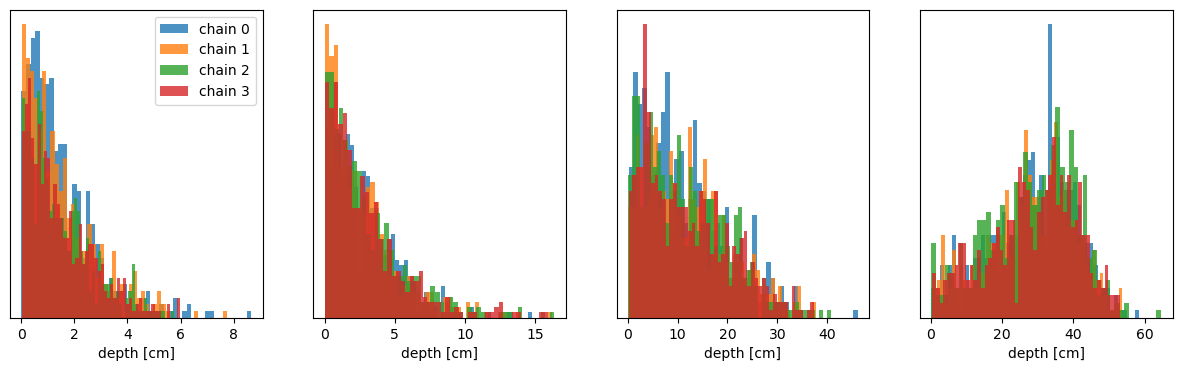

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
all_a_s = iData.posterior[f"lock_in_{core_id}"].values
for it in range(4):
    for chain in range(4):
        axs[it].hist(
            all_a_s[chain, :, it],
            bins=50,
            alpha=0.8,
            color=f"C{chain}",
            label=f"chain {chain}",
        )
        axs[it].set_yticks([])
        axs[it].set_xlabel("depth [cm]")
axs[0].legend()

Chain: 0, Subsection: P2, Mean: -3.3557304437156144
Chain: 1, Subsection: P2, Mean: -3.2428650267871615
Chain: 2, Subsection: P2, Mean: -3.245127275527638
Chain: 3, Subsection: P2, Mean: -3.2302631786816507


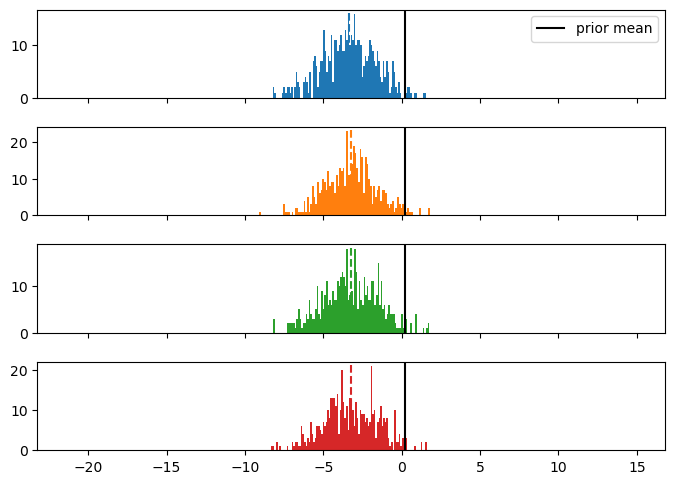

In [35]:
fig, axs = plt.subplots(
    4,
    len(sed.subcores.keys()),
    figsize=(7 * len(sed.subcores.keys()), 5),
    sharex="col",
)
fig.tight_layout()
inp = np.linspace(-20, 20, 1000)
for i, sub in enumerate(sed.subcores.keys()):
    offsets = iData.posterior[f"offset_{sub}"].values
    for chain in range(4):
        ax = axs[chain, i] if len(sed.subcores.keys()) > 1 else axs[chain]
        # ax.hist(
        #     np.random.normal(sed.subcores[sub][1], 50, size=800),
        #     bins=200,
        #     color="grey",
        #     alpha=0.5,
        # )
        ax.hist(offsets[chain], bins=100, color=f"C{chain}")
        print(
            f"Chain: {chain}, Subsection: {sub}, Mean: {np.mean(offsets[chain])}"
        )
        ax.axvline(np.mean(offsets[chain]), ls="--", color=f"C{chain}")
        ax.axvline(sed.subcores[sub][1], c="black", label="prior mean")
        # axs[chain].set_yticks([])
        ax.set_xlim(np.mean(offsets[chain])-20, np.mean(offsets[chain])+20)
    axs[0, 0].set_xlabel("depth [cm]") if len(sed.subcores.keys()) > 1 else axs[0].legend()
    axs[0, 0].legend() if len(sed.subcores.keys()) > 1 else axs[0].legend()

Text(0.5, 0, 'depth [cm]')

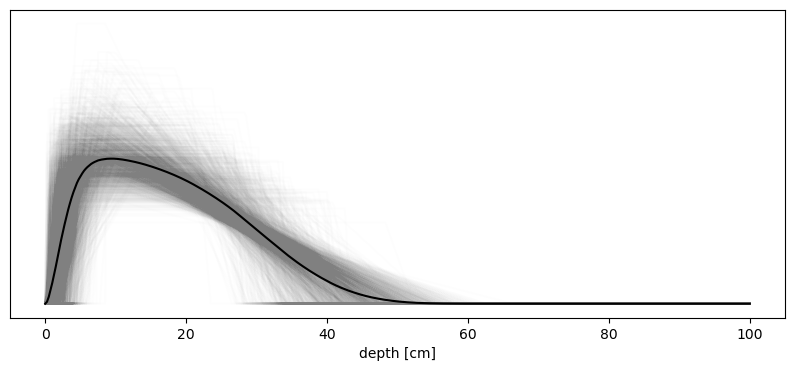

In [37]:
depth = np.linspace(0, 100, 401)
beta = 2 / (b_s[3] + b_s[2] - b_s[1] - b_s[0])
F_01 = 0.0
F_12 = (
    beta[None, :]
    * (depth[:, None] - b_s[0, None, :])
    / (b_s[1] - b_s[0])[None, :]
)
F_23 = beta[None, :]
F_34 = (
    beta[None, :]
    * (b_s[3, None, :] - depth[:, None])
    / (b_s[3] - b_s[2])[None, :]
)
F_4x = 0.0

ind_12 = (b_s[0, None, :] < depth[:, None]) * (
    depth[:, None] <= b_s[1, None, :]
)
ind_23 = (b_s[1, None, :] < depth[:, None]) * (
    depth[:, None] <= b_s[2, None, :]
)
ind_34 = (b_s[2, None, :] < depth[:, None]) * (
    depth[:, None] <= b_s[3, None, :]
)

lis = ind_12 * F_12 + ind_23 * F_23 + ind_34 * F_34

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(depth, lis, alpha=0.01, color="grey")
ax.plot(depth, lis.mean(axis=1), alpha=1, color="black")
ax.set_yticks([])
ax.set_xlabel("depth [cm]")

In [38]:
np.array(iData.posterior[f"f_shallow_{core_id}"]).mean(axis=1)

array([0.97969536, 0.97944198, 0.97945987, 0.97896992])

In [36]:
# gs_at_knots = iData.posterior[f'gs_at_knots'].values.reshape(-1, 35, 185)#.reshape(-1, 35, 161)
# gs_at_knots_full = iData_full.posterior[f'gs_at_knots'].values.reshape(-1, 35, 185)#.reshape(-1, 35, 161)
# gs_at_knots_t_samp = np.array(iData_t_samp.posterior[f'gs_at_knots']).reshape(-1, 35, 281)

In [37]:
# from scipy.interpolate import BSpline
# t_min=min(min(sed_data.t), -6000) - 1000
# t_max=2000
# step=50
# mcmc_knots = np.arange(t_min, t_max+50, 50)
# fig, axs = plt.subplots(35, figsize=(6, 40), sharex=True)
# fig.tight_layout(h_pad=0.02)
# for i in range(35):
#     gs_mean = gs_at_knots[:, i, :].mean(axis=0)
#     gs_std = gs_at_knots[:, i, :].std(axis=0)
#     # gs_mean_samp_t = gs_at_knots_t_samp[:, i, 281 - 161:].mean(axis=0)
#     # gs_std_samp_t = gs_at_knots_t_samp[:, i, 281 - 161:].std(axis=0)
#     gs_mean_samp_t = gs_at_knots_full[:, i, :].mean(axis=0)
#     gs_std_samp_t = gs_at_knots_full[:, i, :].std(axis=0)
#     axs[i].plot(mcmc_knots, gs_mean, label="nigp", c="C1")
#     axs[i].fill_between(mcmc_knots, gs_mean - gs_std, gs_mean + gs_std, color="C1", alpha=0.5)
#     axs[i].plot(mcmc_knots, gs_mean_samp_t, label="samp t", c="C0")
#     axs[i].fill_between(mcmc_knots, gs_mean_samp_t - gs_std_samp_t, gs_mean_samp_t + gs_std_samp_t, color="C0", alpha=0.5)
# axs[0].legend()
# plt.show()

In [38]:
# for i in range(4):
#     plt.hist(
#         np.array(iData.posterior[f'rF_a'])[i].flatten(),
#         bins=np.linspace(-5, 5, 31)
#     )